---

Author      : Dilan Kilic (kilicd15@itu.edu.tr)  <br> 
Student ID  : 511211159  <br> 
created on  : 01.04.2023  <br> 
revised on  : 04.04.2023  <br> 

Description : This code is the implementation of L2 air dataset regression problem including the HPO using Optuna libraies.

---

# Import Libraries

In [1]:
# import libraries

# main
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 28
import pandas as pd
import seaborn as sns
import time

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# grid-search
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# machine learning models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#import xgboost as xgb
#from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

#import skorch
#from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import StepLR

# dimensionality reduction
from sklearn.decomposition import PCA
#from yellowbrick.model_selection import FeatureImportances

# evaluation metrics
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

sns.set_theme(style='darkgrid')

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

import warnings
warnings.filterwarnings('ignore')


import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

In [2]:
# Set the default text font size
plt.rc('font', size=18)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=14)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=14)
# Set the legend font size
plt.rc('legend', fontsize=14)
# Set the font size of the figure title
plt.rc('figure', titlesize=18)

font = {'family' : 'Cambria',
        'weight' : 'normal'}
plt.rc('font', **font)

# Data pre-processing

In [3]:
df   = pd.read_csv("combined_last.csv", sep=",")   # the file uses “;” as separator
df = df[df["Mach"] == 0.15]                      # keep only Mach = 0.85 rows


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mach               150 non-null    float64
 1   YoungsModulus3     150 non-null    float64
 2   Density1           150 non-null    float64
 3   Density3           150 non-null    float64
 4   Flutter Speed      150 non-null    float64
 5   Mass               150 non-null    float64
 6   Flutter Frequency  150 non-null    float64
dtypes: float64(7)
memory usage: 8.3 KB


In [5]:
# Convert specific columns to float
columns_to_convert = [
    'YoungsModulus3'
]

df[columns_to_convert] = df[columns_to_convert].astype(float)

# Display the first few rows to verify the conversion
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mach               150 non-null    float64
 1   YoungsModulus3     150 non-null    float64
 2   Density1           150 non-null    float64
 3   Density3           150 non-null    float64
 4   Flutter Speed      150 non-null    float64
 5   Mass               150 non-null    float64
 6   Flutter Frequency  150 non-null    float64
dtypes: float64(7)
memory usage: 8.3 KB


In [6]:
df.describe()

,Mach,YoungsModulus3,Density1,Density3,Flutter Speed,Mass,Flutter Frequency
count,1.500000e+02,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.500000e-01,7.089228e+10,929.426820,2794.274193,67.516295,0.356465,34.591000
std,2.227885e-16,5.250291e+09,46.846696,87.594540,2.409610,0.009081,1.278643
min,1.500000e-01,6.200000e+10,850.000000,2645.000000,63.200179,0.334779,32.089895
25%,1.500000e-01,6.642913e+10,889.000250,2718.548750,65.467131,0.350311,33.547514
50%,1.500000e-01,7.100000e+10,929.333500,2793.790500,67.614295,0.356267,34.475215
75%,1.500000e-01,7.542913e+10,969.666750,2869.395250,69.551093,0.362871,35.550819
max,1.500000e-01,8.000000e+10,1010.000000,2945.000000,71.877323,0.375908,37.365350


In [7]:
# prepare X and y
X = df[['YoungsModulus3','Density1','Density3']]
y = df[['Flutter Speed']]

# print
print('Input shape: ', X.shape)
print('Output shape: ', y.shape)

Input shape:  (150, 3)
Output shape:  (150, 1)


In [8]:
from sklearn.ensemble import IsolationForest

def clean_outliers(X, y, contamination=0.1):
    # Combine X and y for outlier detection
    data = pd.concat([X, y], axis=1)

    # Fit the model
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)

    # Predict the outliers
    y_pred = clf.predict(data)

    # Filter the data
    mask = y_pred != -1
    X_clean = X[mask]
    y_clean = y[mask]

    return X_clean, y_clean

# Clean outliers from X and y
X_clean, y_clean = clean_outliers(X, y, contamination=0.1)

print(f"Original X shape: {X.shape}")
print(f"Cleaned X shape: {X_clean.shape}")
print(f"Original y shape: {y.shape}")
print(f"Cleaned y shape: {y_clean.shape}")

Original X shape: (150, 3)
Cleaned X shape: (135, 3)
Original y shape: (150, 1)
Cleaned y shape: (135, 1)


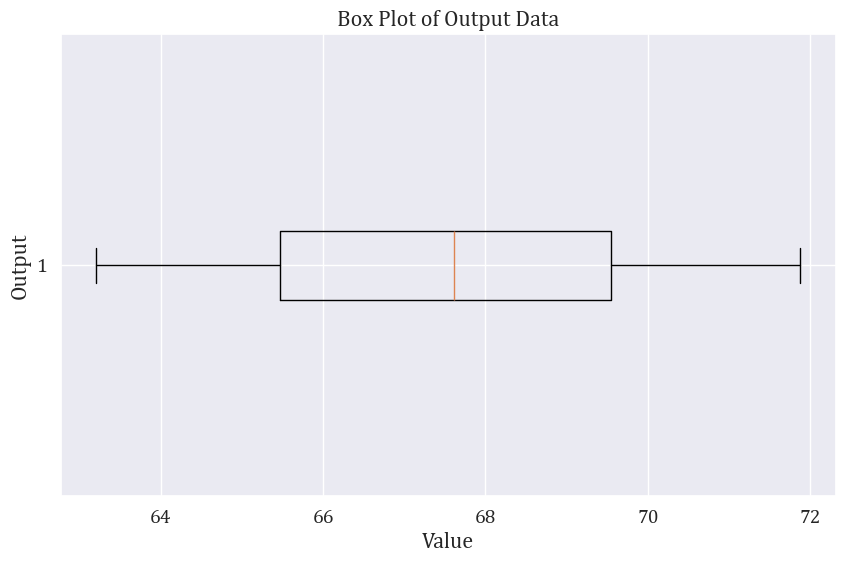

In [9]:
# Plot box plot for the y output
plt.figure(figsize=(10, 6))
plt.boxplot(y, vert=False)
plt.title('Box Plot of Output Data')
plt.xlabel('Value')
plt.ylabel('Output')
plt.show()

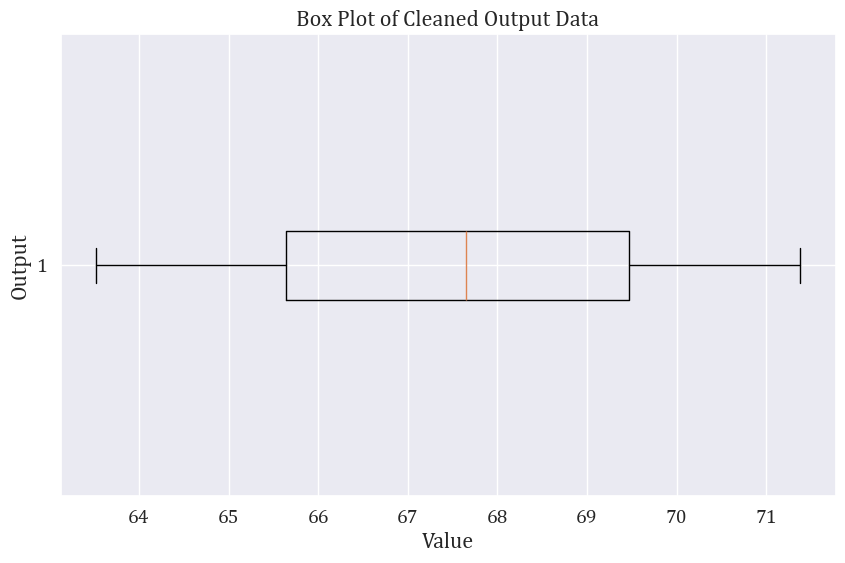

In [10]:
# Plot box plot for the y output
plt.figure(figsize=(10, 6))
plt.boxplot(y_clean, vert=False)
plt.title('Box Plot of Cleaned Output Data')
plt.xlabel('Value')
plt.ylabel('Output')
plt.show()

In [11]:
X, y = X_clean, y_clean

In [12]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score

# ------------------------------------------------------------------
# 1) split data
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y.squeeze(),           # <-- make sure y is 1-D
    test_size=0.20,
    shuffle=True,
    random_state=42
)

# ------------------------------------------------------------------
# 2) helper that builds the end-to-end estimator
#    (X-scaler → SVR)   + automatic y-scaler
# ------------------------------------------------------------------
def build_model(C, epsilon, gamma):
    inner = Pipeline(
        [
            ("x_scaler", MinMaxScaler()),
            ("svr", SVR(C=C, epsilon=epsilon, gamma=gamma)),
        ]
    )

    # scales / inverse-scales the *target* transparently
    return TransformedTargetRegressor(
        regressor=inner,
        transformer=MinMaxScaler()
    )

# ------------------------------------------------------------------
# 3) Optuna objective
# ------------------------------------------------------------------
def objective(trial):
    params = {
        "C":       trial.suggest_loguniform("C",       1e-4, 1e4),
        "epsilon": trial.suggest_loguniform("epsilon", 1e-4, 1e1),
        "gamma":   trial.suggest_loguniform("gamma",   1e-4, 1e1),
    }

    model = build_model(**params)
    model.fit(X_train, y_train)          # scaled in / scaled out

    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# ------------------------------------------------------------------
# 4) hyper-parameter search
# ------------------------------------------------------------------
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)
print("Best params →", study.best_params)

# ------------------------------------------------------------------
# 5) final fit & report
# ------------------------------------------------------------------
best_model = build_model(**study.best_params)
best_model.fit(X_train, y_train)

print(f"Train R²: {r2_score(y_train, best_model.predict(X_train)):.4f}")
print(f"Test  R²: {r2_score(y_test , best_model.predict(X_test )):.4f}")


[I 2025-06-16 07:40:21,605] A new study created in memory with name: no-name-31831003-8669-4b1b-b745-c454b5830b47
[I 2025-06-16 07:40:21,623] Trial 0 finished with value: 0.09178944907793207 and parameters: {'C': 0.0023185301424879065, 'epsilon': 0.0005245458035906807, 'gamma': 8.934116299632729}. Best is trial 0 with value: 0.09178944907793207.
[I 2025-06-16 07:40:21,639] Trial 1 finished with value: 0.9999567882576342 and parameters: {'C': 3865.80718539247, 'epsilon': 0.0033575250779052015, 'gamma': 0.0020189428192863897}. Best is trial 1 with value: 0.9999567882576342.
[I 2025-06-16 07:40:21,661] Trial 2 finished with value: 0.9994155174090393 and parameters: {'C': 0.834231363582194, 'epsilon': 0.00031936083471062075, 'gamma': 4.058590133715178}. Best is trial 1 with value: 0.9999567882576342.
[I 2025-06-16 07:40:21,672] Trial 3 finished with value: 0.9993013086684162 and parameters: {'C': 1.8356621635896355, 'epsilon': 0.004958583258891782, 'gamma': 0.4204461552875051}. Best is tri

Best params → {'C': 134.35191996885075, 'epsilon': 0.00018862920801842936, 'gamma': 0.18316205357877616}
Train R²: 1.0000
Test  R²: 1.0000


In [13]:
# ------------------------------------------------------------------
# 6) example inference
# ------------------------------------------------------------------
query = pd.DataFrame(
    {
        "YoungsModulus3": [76740157480.315],
        "Density1": [964.0],
        "Density3": [2729.677],
    }
)
print("Predicted Flutter Speed:", best_model.predict(query).item())

Predicted Flutter Speed: 70.04815833411793


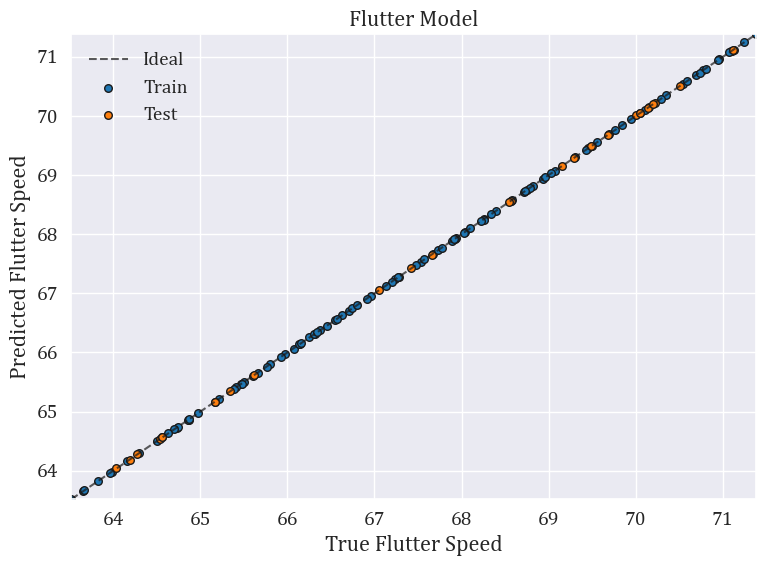

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# predictions are already in original units with the new pipeline
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

# 1-to-1 reference line
lims = [
    min(y_train.min(), y_test.min(), y_train_pred.min(), y_test_pred.min()),
    max(y_train.max(), y_test.max(), y_train_pred.max(), y_test_pred.max()),
]

plt.figure(figsize=(8, 6))
plt.plot(lims, lims, "k--", alpha=0.7, label="Ideal")

plt.scatter(y_train, y_train_pred,  s=30, c="tab:blue",   edgecolors="k", label="Train")
plt.scatter(y_test , y_test_pred ,  s=30, c="tab:orange", edgecolors="k", label="Test")

plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True Flutter Speed")
plt.ylabel("Predicted Flutter Speed")
plt.title("Flutter Model")
#plt.title(
#    f"Flutter Speed surrogate: R² train = {r2_score(y_train, y_train_pred):.3f} · "
#    f"R² test = {r2_score(y_test , y_test_pred ):.3f}"
#)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [15]:
import joblib

# `best_model` is the single TransformedTargetRegressor that already
# contains the X-scaler and the SVR inside.
joblib.dump(best_model, "flutter_svr_pipeline.pkl")

# … later …
# best_model = joblib.load("mass_svr_pipeline.pkl")
# y_hat      = best_model.predict(new_X)


['flutter_svr_pipeline.pkl']